# Chest X ray CAD ResNet 101d

In [21]:
import os
import sys
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

import glob
import random
import cv2

import datetime

from torchinfo import summary
import torch.optim as optim
from torch.utils.data import DataLoader
import tqdm
import torch
#import gc

import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import datetime
import configparser

import timm
import timm.data
import timm.data.config

import numpy as np
import pandas as pd
import pickle

In [2]:
def timestamp():
    time_cur = datetime.datetime.now()
    print('datetime:',time_cur.strftime('%m/%d %H:%M'))
    stamp = time_cur.strftime('%Y%m%d%H%M')
    return(stamp)

stamp = timestamp()

datetime: 07/22 15:05


In [3]:
config = configparser.ConfigParser()

config["model"] = {"rand_seed": 765,
                   "model_name": "resnet101d",
                   "n_pix": 512,
                   "learning_rate": 1e-4,
                   "loss_cls_type": "BCEWithLogit",
                   "optimizer": "Adam", # "Adagrad", "Adam"
                   "loader": "Resample 3 label", # "Resample 2 label", "Resample 3 label",
                   "augment_func": "Random Affine", # "Random Rotate", "Random Affine",
                   "drop_rate": 0.5,
                   "target_type": "both",
                   "cross_validation": 10,
                   "batch_size" : 1
                }

config.write(sys.stdout)

path_config = "dat1/params_{}.txt".format(stamp)
with open(path_config, "w") as fp_config:
#    config.write(fp_config)
    print("Save parameters as ", path_config)

rand_seed  = int(config["model"]["rand_seed"])
random.seed(rand_seed)
np.random.seed(rand_seed)
torch.random.manual_seed(rand_seed)
torch.cuda.manual_seed(rand_seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

model_name = str(config["model"]["model_name"])

n_pix = int(config["model"]["n_pix"])

learning_rate = float(config["model"]["learning_rate"])

loss_cls_type = str(config["model"]["loss_cls_type"])

optimizer = str(config["model"]["optimizer"])

loader = str(config["model"]["loader"])

augment_func = str(config["model"]["augment_func"])

drop_rate = float(config["model"]["drop_rate"])

target_type = str(config["model"]["target_type"])

cross_validation = int(config["model"]["cross_validation"])

batch_size = int(config["model"]["batch_size"])


[model]
rand_seed = 765
model_name = resnet101d
n_pix = 512
learning_rate = 0.0001
loss_cls_type = BCEWithLogit
optimizer = Adam
loader = Resample 3 label
augment_func = Random Affine
drop_rate = 0.5
target_type = both
cross_validation = 10
batch_size = 1

Save parameters as  dat1/params_202307221505.txt


In [4]:
diagnosis1 = pd.read_csv("data/sample.csv")
diagnosis1.columns=['胸部Ｘ線番号', '胸部所見判定[コード]', '胸部所見判定[名称]', '胸膜肥厚', '側弯', '気胸', '胸部部位コード1',
       '胸部部位名称1', '胸部所見コード1', '胸部所見名称1', '胸部部位コード2', '胸部部位名称2', '胸部所見コード2',
       '胸部所見名称2', '胸部部位コード3', '胸部部位名称3', '胸部所見コード3', '胸部所見名称3', '胸部部位コード4',
       '胸部部位名称4', '胸部所見コード4', '胸部所見名称4']

diagnosis2 = pd.read_csv("data/test_sample.csv")
pix_all = np.load("data/sample.npy")
pix_20210708 = np.load("data/test_sample.npy")
print(diagnosis1.shape)
print(pix_all.shape)
n_sample, ny, nx = pix_all.shape

(12, 22)
(12, 512, 512)


In [5]:
target_pleural = (diagnosis1["胸膜肥厚"]=="有").to_numpy().astype(int)
target_scoliosis = (diagnosis1["側弯"]=="有").to_numpy().astype(int)

print(np.sum(target_pleural))
print(np.sum(target_scoliosis))


4
4


In [6]:
if(target_type=="pleural"):
    print("pleural")
    target_all = np.zeros((len(diagnosis1),2),dtype=np.uint8)
    target_all[target_pleural==0,0] = 1
    target_all[target_pleural==1,1] = 1

    target_1k = np.zeros((n_sample,2),dtype=np.uint8)
    target_1k[:,0][diagnosis2["胸膜肥厚"]=="No"] = 1
    target_1k[:,1][diagnosis2["胸膜肥厚"]!="No"] = 1 # R, L, RL

if(target_type=="scoliosis"):
    print("scoliosis")
    target_all = np.zeros((len(diagnosis1),2),dtype=np.uint8)
    target_all[target_scoliosis==0,0] = 1
    target_all[target_scoliosis==1,1] = 1

    target_1k = np.zeros((n_sample,2),dtype=np.uint8)
    target_1k[:,0][diagnosis2["側弯"]=="No"] = 1
    target_1k[:,1][diagnosis2["側弯"]=="有"] = 1

if(target_type=="both"):
    print("both")
    target_all = np.zeros((len(diagnosis1),2),dtype=np.uint8)
    target_all[:,0][target_pleural==1] = 1
    target_all[:,1][target_scoliosis==1] = 1

    target_1k = np.zeros((n_sample,2),dtype=np.uint8)
    target_1k[:,0][diagnosis2["胸膜肥厚"]!="No"] = 1 # R, L, RL
    target_1k[:,1][diagnosis2["側弯"]=="有"] = 1


both


## Cross Validation

Divide training data 


In [7]:
idx_trn = np.arange(n_sample)
np.random.shuffle(idx_trn)
idx_cv10 = np.array_split(idx_trn, 10)
idx_val = np.sort(idx_cv10[0])
idx_trn = np.sort(np.setdiff1d(idx_trn, idx_val))
print(len(idx_val))
print(len(idx_trn))

2
10


In [8]:
input_config = timm.data.config.resolve_data_config({}, model=model_name, verbose=True)
input_size = input_config["input_size"]
input_mean = input_config["mean"]
input_std = input_config["std"]


In [9]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet,self).__init__()
        print("model:", model_name)
        self.model  = timm.create_model(model_name, pretrained=True)
        self.classifier = nn.Sequential(
                                nn.Linear(1000, 512),
                                nn.Dropout(drop_rate),
                                nn.LeakyReLU(0.1),
                                nn.Linear(512, 128),
                                nn.Dropout(drop_rate),
                                nn.LeakyReLU(0.1),
                                nn.Linear(128, 2),
                                )

    def forward(self,x):
        x = self.model(x)
        x = self.classifier(x)
        return(x)

In [10]:
torch.cuda.empty_cache()
model1 = MyNet().cuda()
summary(model1, input_size=(batch_size, 3, ny, nx))

model: resnet101d


Layer (type:depth-idx)                        Output Shape              Param #
MyNet                                         --                        --
├─ResNet: 1-1                                 [1, 1000]                 --
│    └─Sequential: 2-1                        [1, 64, 256, 256]         --
│    │    └─Conv2d: 3-1                       [1, 32, 256, 256]         864
│    │    └─BatchNorm2d: 3-2                  [1, 32, 256, 256]         64
│    │    └─ReLU: 3-3                         [1, 32, 256, 256]         --
│    │    └─Conv2d: 3-4                       [1, 32, 256, 256]         9,216
│    │    └─BatchNorm2d: 3-5                  [1, 32, 256, 256]         64
│    │    └─ReLU: 3-6                         [1, 32, 256, 256]         --
│    │    └─Conv2d: 3-7                       [1, 64, 256, 256]         18,432
│    └─BatchNorm2d: 2-2                       [1, 64, 256, 256]         128
│    └─ReLU: 2-3                              [1, 64, 256, 256]         --
│    └─MaxP

In [11]:
optim1 = optim.Adam(model1.parameters(), lr=learning_rate)
loss_func = nn.BCEWithLogitsLoss()


In [12]:

class HistDict():
    def __init__(self, keys):
        """
        Class that stores the model's evaluation values in a dictionary type.

        Args:
            keys (list): List of keys to represent the categories.

        Returns:
            None
        """
        self.values = {}
        for kk in keys:
            self.values[kk] = []
        self.keys = keys
        
    def append(self, dict_hist):
        """
        Append values from the input dictionary to the corresponding keys in the HistDict.

        Args:
            dict_hist (dict): Dictionary containing values to be appended.

        Returns:
            None
        """
        for kk in dict_hist.keys():
            self.values[kk].append(dict_hist[kk])
            
    def mean(self, keys=None):
        """
        Calculate the mean of the values for the specified keys or all keys.

        Args:
            keys (list, optional): List of keys for which to calculate the mean. 
                If None, the mean will be calculated for all keys.

        Returns:
            dict: A dictionary containing the means for each key.
        """
        if(keys is None):
            keys = self.keys
        mm = {}
        for kk in keys: 
            mm[kk] = np.round(np.mean(self.values[kk]), 6)
        return mm

    def __getitem__(self, key):
        """
        Get values for the specified key.

        Args:
            key (str): The key for which to retrieve the values.

        Returns:
            list: A list of values corresponding to the key.
        """
        return self.values[key]
    
    def to_str(self, keys=None):
        """
        Convert the HistDict values to a string representation.

        Args:
            keys (list, optional): List of keys for which to create the string representation. 
                If None, the string will be created for all keys.

        Returns:
            list: A list of strings representing the values for each key.
        """
        if(keys is None):
            keys = self.keys
        sss = [kk + ":" + str(self.values[kk]) for kk in keys]
        return sss

    def DataFrame(self):
        """
        Create a pandas DataFrame from the HistDict values.

        Args:
            None

        Returns:
            pandas.DataFrame: A DataFrame with the HistDict values.
        """
        tmp = pd.DataFrame.from_dict(self.values)
        return tmp


In [13]:
def make_batch_list(idx, batch_size=100, n_batch=None, shuffle=True):
    """
    Creates a list of batches from given indices.

    Args:
        idx (array-like): The indices to be divided into batches.
        batch_size (int): The desired batch size (default: 100).
        n_batch (int, optional): The number of batches to create. If not provided, it is calculated based on idx and batch_size.
        shuffle (bool): Whether to shuffle the indices before creating batches (default: True).

    Returns:
        batch_list (list): A list of batches containing the divided indices.

    """
    # Calculate the number of batches if not provided
    if n_batch is None:
        n_batch = len(idx) // batch_size

    # Shuffle the indices if requested
    if shuffle:
        np.random.shuffle(idx)

    # Divide the indices into batches
    batch_list = np.array_split(idx, n_batch)

    return batch_list


In [14]:
transform_trn = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomAffine(degrees=7.2, translate=(0.02,0.02), scale=(0.98,1.02)),
    transforms.Lambda(lambda x: x.view(1,ny, nx).expand(3,-1,-1)),
    transforms.Normalize(input_mean, input_std),
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(1,ny, nx).expand(3,-1,-1)),
    transforms.Normalize(input_mean, input_std),
])


def generate_batch(idx, pix, target, augment=False):
    """
    Generates a batch of data samples and their corresponding targets.

    Args:
        idx (list or array-like): The indices of the samples to be included in the batch.
        pix (list or array-like): The pixel data of the samples.
        target (list or array-like): The target values corresponding to the samples.
        augment (bool): Whether to apply data augmentation (default: False).

    Returns:
        x_batch (torch.Tensor): The batch of input data samples.
        y_batch (torch.Tensor): The batch of target values.

    """
    epsilon = 1e-8
    tmp = []

    for ii in idx:
        if augment:
            augmented_pix= transform_trn(pix[ii])  # Apply training data augmentation to the sample
        else:
            augmented_pix = transform_val(pix[ii])  # Apply validation data transformation to the sample
        tmp.append(augmented_pix)

    # Convert the list of transformed samples into a torch tensor
    x_batch = torch.stack(tmp, dim=0)

    # Create a torch tensor for the corresponding target values
    y_batch = torch.FloatTensor(target[idx])

    return x_batch.cuda(), y_batch.cuda()

# CV10

In [15]:

path_save = "dat1/resnet101d_{}_0.ckpt".format(stamp)
torch.save(model1.state_dict(), path_save)
print("Save the initial model1: ",path_save)


Save the initial model1:  dat1/resnet101d_202307221505_0.ckpt


In [16]:
def train1(t_epoch, t_log):
    """
    Trains the model for a specified number of epochs.

    Args:
        t_epoch (int): The number of epochs to train.
        t_log (int): The interval for logging the training progress.

    Returns:
        hist_tt (HistDict): The history of training and validation metrics.
                            training - loss_trn : history of BCE Loss value in training phase.
                            validation - loss_val : history of BCE Loss value in validation phase.
                                         acc_p : history of accuracy value for pleaural in validation phase.
                                         acc_s : history of accuracy value for scoliosis in validation phase.
    """
    timestamp()
    
    t0 = 0
    key_trn = ["loss_trn",]
    key_val = ["loss_val", "acc_p", "acc_s",]

    hist_tt = HistDict(["tt"] + key_trn + key_val)

    for tt in range(t0, t0+t_epoch):
        model1.train()
        #create batch index list
        batch_list = make_batch_list(idx_trn, batch_size=batch_size, shuffle=True)
        
        hist_batch = HistDict(key_trn)
        with tqdm(batch_list, leave=False) as pbar:
            for idx_tmp in pbar:
                pbar.set_description("Train")
                #Create data (pix data and label data) based on batch index.
                xxx_tmp, yyy_tmp = generate_batch(idx_tmp, pix_all, target_all, augment=True)

                out_tmp = model1(xxx_tmp)
                loss_tmp = loss_func(out_tmp, yyy_tmp)

                optim1.zero_grad()
                loss_tmp.backward()
                optim1.step()
                hist_batch.append({"loss_trn":loss_tmp.item(),})

        hist_trn = hist_batch.mean()

        hist_batch = HistDict(key_val)
        model1.eval()
        with torch.inference_mode():
            #create batch index list
            batch_list = make_batch_list(idx_val, batch_size=batch_size, shuffle=False)
            with tqdm(batch_list, leave=False) as pbar:
                for idx_tmp in (pbar):
                    pbar.set_description("Validation")
                    #Create data (pix data and label data) based on batch index.
                    xxx_tmp, yyy_tmp = generate_batch(idx_tmp, pix_all, target_all, augment=False)

                    out_tmp = model1(xxx_tmp)
                    loss_tmp = loss_func(out_tmp, yyy_tmp)

                    acc_p = torch.sum((out_tmp[:,0] > 0.5) == (yyy_tmp[:,0]==1)) / len(yyy_tmp)
                    acc_s = torch.sum((out_tmp[:,1] > 0.5) == (yyy_tmp[:,1]==1)) / len(yyy_tmp)
                    hist_batch.append({"loss_val":loss_tmp.item(), "acc_p":acc_p.item(), "acc_s":acc_s.item(),})

        hist_val = hist_batch.mean()

        hist_tt.append({"tt":tt})
        hist_tt.append(hist_trn)
        hist_tt.append(hist_val)

        if (tt+1) % t_log == 0:
            print((tt+1), np.round(hist_trn["loss_trn"],3), np.round(hist_val["loss_val"],3))

    torch.cuda.empty_cache()
    return hist_tt



In [17]:
# resnet101d_202212031645_0
# resnet101d_202212071027_0
stamp_load = "202307221317"
print(stamp_load)
t0_load = 0

202307221317


In [18]:
hist_cv = []

t_epoch = 5

for cv in range(10):
    idx_val = idx_cv10[cv]
    idx_trn = np.setdiff1d(np.arange(n_sample), idx_val)

    hist_cv.append(None)

    # reset 
    path_load = "dat1/resnet101d_{}_0.ckpt".format(stamp)
    model1.load_state_dict(torch.load(path_load))
    optim1 = optim.Adam(model1.parameters(), lr=learning_rate, amsgrad=True)

    # train
    hist_cv[cv] = train1(t_epoch, 1)
    
    # save
    path_save = "dat1/resnet101d_{}_cv{}_t{}.ckpt".format(stamp, cv, t_epoch)
    print("Save model:", path_save)
    torch.save(model1.state_dict(), path_save)

    path_save = "dat1/hist_resnet101d_{}_cv{}_t{}.csv".format(stamp, cv, t_epoch)
    hist_cv[cv].DataFrame().to_csv(path_save)
    print("Save hist", path_save)


datetime: 07/22 15:05


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

1 0.678 0.711


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

2 0.67 0.741


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

3 0.634 0.768


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

4 0.582 0.807


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

5 0.547 0.846
Save model: dat1/resnet101d_202307221505_cv0_t5.ckpt
Save hist dat1/hist_resnet101d_202307221505_cv0_t5.csv
datetime: 07/22 15:05


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

1 0.695 0.671


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

2 0.68 0.652


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

3 0.684 0.654


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

4 0.682 0.647


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

5 0.647 0.644
Save model: dat1/resnet101d_202307221505_cv1_t5.ckpt
Save hist dat1/hist_resnet101d_202307221505_cv1_t5.csv
datetime: 07/22 15:05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

1 0.693 0.681


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

2 0.679 0.646


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

3 0.667 0.62


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

4 0.669 0.593


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

5 0.66 0.575
Save model: dat1/resnet101d_202307221505_cv2_t5.ckpt
Save hist dat1/hist_resnet101d_202307221505_cv2_t5.csv
datetime: 07/22 15:06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

1 0.702 0.685


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

2 0.68 0.631


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

3 0.659 0.596


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

4 0.646 0.579


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

5 0.665 0.595
Save model: dat1/resnet101d_202307221505_cv3_t5.ckpt
Save hist dat1/hist_resnet101d_202307221505_cv3_t5.csv
datetime: 07/22 15:06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

1 0.695 0.686


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

2 0.648 0.716


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

3 0.648 0.77


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

4 0.619 0.84


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

5 0.652 0.83
Save model: dat1/resnet101d_202307221505_cv4_t5.ckpt
Save hist dat1/hist_resnet101d_202307221505_cv4_t5.csv
datetime: 07/22 15:06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

1 0.689 0.724


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

2 0.685 0.74


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

3 0.658 0.741


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

4 0.629 0.785


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

5 0.666 0.806
Save model: dat1/resnet101d_202307221505_cv5_t5.ckpt
Save hist dat1/hist_resnet101d_202307221505_cv5_t5.csv
datetime: 07/22 15:06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

1 0.69 0.685


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

2 0.679 0.706


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

3 0.652 0.759


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

4 0.639 0.727


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

5 0.591 0.791
Save model: dat1/resnet101d_202307221505_cv6_t5.ckpt
Save hist dat1/hist_resnet101d_202307221505_cv6_t5.csv
datetime: 07/22 15:06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

1 0.69 0.668


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

2 0.686 0.616


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

3 0.665 0.604


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

4 0.688 0.602


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

5 0.665 0.622
Save model: dat1/resnet101d_202307221505_cv7_t5.ckpt
Save hist dat1/hist_resnet101d_202307221505_cv7_t5.csv
datetime: 07/22 15:07


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

1 0.693 0.678


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

2 0.664 0.695


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

3 0.635 0.712


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

4 0.635 0.731


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

5 0.613 0.747
Save model: dat1/resnet101d_202307221505_cv8_t5.ckpt
Save hist dat1/hist_resnet101d_202307221505_cv8_t5.csv
datetime: 07/22 15:07


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

1 0.686 0.742


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

2 0.67 0.708


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

3 0.634 0.715


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

4 0.612 0.781


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

5 0.616 0.82
Save model: dat1/resnet101d_202307221505_cv9_t5.ckpt
Save hist dat1/hist_resnet101d_202307221505_cv9_t5.csv


# Evaluation

In [19]:
target_all_eval=np.load("dat1/target_all.npy")
target_1k_eval=np.load("dat1/target_1k.npy")

In [22]:
target_type = "both"
print(target_type)
flag = {}

with open("dat1/flag.pkl", "rb") as tf:
    flag = pickle.load(tf)


for kk in flag["scoliosis"].keys():
    print(kk,'\t', np.sum(flag["scoliosis"][kk]))
# # target="scoliosis"
# # target="pleural"
# target_type = "both"
# print(target_type)
# flag = {}

# print("pleural")

# flag["pleural"] = {}
# flag["pleural"]["1_"] = diagnosis2.iloc[:,5].notna()
# flag["pleural"]["0_"] = diagnosis2.iloc[:,5].isna()
# flag["pleural"]["_1"] = diagnosis2.iloc[:,7].notna()
# flag["pleural"]["_0"] = diagnosis2.iloc[:,7].isna()

# flag["pleural"]["_11"] = np.logical_and(flag["pleural"]["1_"], flag["pleural"]["_1"])
# flag["pleural"]["_10"] = np.logical_and(flag["pleural"]["1_"], flag["pleural"]["_0"])
# flag["pleural"]["_01"] = np.logical_and(flag["pleural"]["0_"], flag["pleural"]["_1"])
# flag["pleural"]["_00"] = np.logical_and(flag["pleural"]["0_"], flag["pleural"]["_0"])

# flag["pleural"]["2__"] = diagnosis2.iloc[:,3]!="No"
# flag["pleural"]["0__"] = diagnosis2.iloc[:,3]=="No"

# flag["pleural"]["211"] = np.logical_and(flag["pleural"]["2__"], flag["pleural"]["_11"])
# flag["pleural"]["210"] = np.logical_and(flag["pleural"]["2__"], flag["pleural"]["_10"])
# flag["pleural"]["201"] = np.logical_and(flag["pleural"]["2__"], flag["pleural"]["_01"])
# flag["pleural"]["200"] = np.logical_and(flag["pleural"]["2__"], flag["pleural"]["_00"])

# flag["pleural"]["011"] = np.logical_and(flag["pleural"]["0__"], flag["pleural"]["_11"])
# flag["pleural"]["010"] = np.logical_and(flag["pleural"]["0__"], flag["pleural"]["_10"])
# flag["pleural"]["001"] = np.logical_and(flag["pleural"]["0__"], flag["pleural"]["_01"])
# flag["pleural"]["000"] = np.logical_and(flag["pleural"]["0__"], flag["pleural"]["_00"])

# flag["pleural"]["22"] = flag["pleural"]["211"]
# flag["pleural"]["21"] = np.logical_or(flag["pleural"]["210"], flag["pleural"]["201"])
# flag["pleural"]["20"] = flag["pleural"]["200"]
# flag["pleural"]["02"] = flag["pleural"]["011"]
# flag["pleural"]["01"] = np.logical_or(flag["pleural"]["010"], flag["pleural"]["001"])
# flag["pleural"]["00"] = flag["pleural"]["000"]

# for kk in flag["pleural"].keys():
#     print(kk,'\t', np.sum(flag["pleural"][kk]))

# print("scoliosis")
# flag["scoliosis"] = {}
# flag["scoliosis"]["1_"] = diagnosis2.iloc[:,6]=="有"
# flag["scoliosis"]["0_"] = diagnosis2.iloc[:,6]!="有"
# flag["scoliosis"]["_1"] = diagnosis2.iloc[:,8]=="有"
# flag["scoliosis"]["_0"] = diagnosis2.iloc[:,8]!="有"

# flag["scoliosis"]["_11"] = np.logical_and(flag["scoliosis"]["1_"], flag["scoliosis"]["_1"])
# flag["scoliosis"]["_10"] = np.logical_and(flag["scoliosis"]["1_"], flag["scoliosis"]["_0"])
# flag["scoliosis"]["_01"] = np.logical_and(flag["scoliosis"]["0_"], flag["scoliosis"]["_1"])
# flag["scoliosis"]["_00"] = np.logical_and(flag["scoliosis"]["0_"], flag["scoliosis"]["_0"])

# flag["scoliosis"]["2__"] = diagnosis2.iloc[:,4]!="No"
# flag["scoliosis"]["0__"] = diagnosis2.iloc[:,4]=="No"

# flag["scoliosis"]["211"] = np.logical_and(flag["scoliosis"]["2__"], flag["scoliosis"]["_11"])
# flag["scoliosis"]["210"] = np.logical_and(flag["scoliosis"]["2__"], flag["scoliosis"]["_10"])
# flag["scoliosis"]["201"] = np.logical_and(flag["scoliosis"]["2__"], flag["scoliosis"]["_01"])
# flag["scoliosis"]["200"] = np.logical_and(flag["scoliosis"]["2__"], flag["scoliosis"]["_00"])

# flag["scoliosis"]["011"] = np.logical_and(flag["scoliosis"]["0__"], flag["scoliosis"]["_11"])
# flag["scoliosis"]["010"] = np.logical_and(flag["scoliosis"]["0__"], flag["scoliosis"]["_10"])
# flag["scoliosis"]["001"] = np.logical_and(flag["scoliosis"]["0__"], flag["scoliosis"]["_01"])
# flag["scoliosis"]["000"] = np.logical_and(flag["scoliosis"]["0__"], flag["scoliosis"]["_00"])

# flag["scoliosis"]["22"] = flag["scoliosis"]["211"]
# flag["scoliosis"]["21"] = np.logical_or(flag["scoliosis"]["210"], flag["scoliosis"]["201"])
# flag["scoliosis"]["20"] = flag["scoliosis"]["200"]
# flag["scoliosis"]["02"] = flag["scoliosis"]["011"]
# flag["scoliosis"]["01"] = np.logical_or(flag["scoliosis"]["010"], flag["scoliosis"]["001"])
# flag["scoliosis"]["00"] = flag["scoliosis"]["000"]

# for kk in flag["scoliosis"].keys():
#     print(kk,'\t', np.sum(flag["scoliosis"][kk]))
    


both
1_ 	 35
0_ 	 965
_1 	 35
_0 	 965
_11 	 28
_10 	 7
_01 	 7
_00 	 958
2__ 	 27
0__ 	 973
211 	 19
210 	 1
201 	 1
200 	 6
011 	 9
010 	 6
001 	 6
000 	 952
22 	 19
21 	 2
20 	 6
02 	 9
01 	 12
00 	 952


In [23]:
# key6 = ["000",("001","010"),"011","200",("201","210"),"211"]
key6 = ["00","01","02","20","21","22"]
label6 = {"00":"N,NN", 
          "01":"N,PN",
          "02":"N,PP",
          "20":"P,NN",
          "21":"P,PN",
          "22":"P,PP",
         }
p_hat = {}
p_hat["00"] = 1/6
p_hat["01"] = 2/6
p_hat["02"] = 3/6
p_hat["20"] = 3/8
p_hat["21"] = 4/7
p_hat["22"] = 7/9

p_hat6 = np.array([ p_hat[kk] for kk in key6 ])
idx_p6 = np.argsort(p_hat6)


In [24]:
from sklearn import metrics

# model1_202211222151_30_cv9
# resnet50d_202212031645_cv8_t5
# resnet101d_202212071143_cv9_t5.ckpt
stamp_load = "202212071143"
t0_load = 5
prd_all = np.load(f"dat1/resnet101d_{stamp_load}_prd_all.npy")
prd_1k_cv = np.load(f"dat1/resnet101d_{stamp_load}_prd_1k_cv.npy")


In [25]:
print(prd_all.shape)
print(prd_1k_cv.shape)

(82005, 2)
(10, 1000, 2)


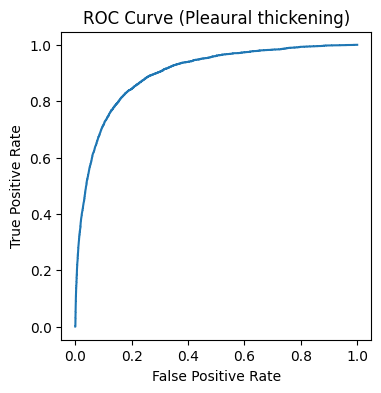

AUC= 0.8991080592765828
-3.1771011352539062
[[ 3112   650]
 [13809 64434]]
[[ 25933.3   5416.7]
 [115075.  536950. ]]


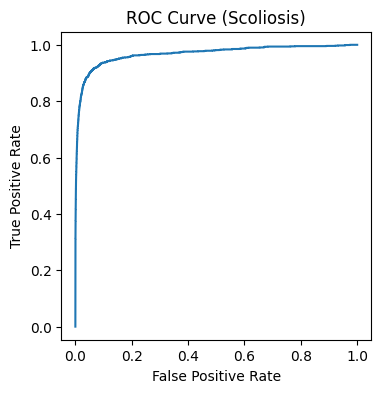

AUC= 0.9683419017942042
-4.378538608551025
[[ 1173   109]
 [ 5208 75515]]
[[  9775.     908.3]
 [ 43400.  629291.7]]


In [27]:
from sklearn import metrics

# pleural
fpr_p, tpr_p, theta = metrics.roc_curve(target_all_eval[:,0], prd_all[:,0])
plt.figure(figsize=(4,4))
plt.plot(fpr_p, tpr_p)
plt.title("ROC Curve (Pleaural thickening)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.axis("equal")
plt.savefig("AUC_pleu.{}.pdf".format(stamp))
plt.show()
auc_p = metrics.auc(fpr_p, tpr_p)
print("AUC=", auc_p)

ii = np.argmin(fpr_p - tpr_p)
theta_p = theta[ii]
print(theta_p)
cls_p = prd_all[:,0] > theta_p
conf_p = metrics.confusion_matrix(1-target_all_eval[:,0], 1-cls_p)
print(conf_p)
print(np.round( (conf_p/n_sample)*100, 1))

# scoliosis
fpr_s, tpr_s, theta = metrics.roc_curve(target_all_eval[:,1], prd_all[:,1])
plt.figure(figsize=(4,4))
plt.plot(fpr_s, tpr_s)
plt.title("ROC Curve (Scoliosis)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.axis("equal")
plt.savefig("AUC_scol.{}.pdf".format(stamp))
plt.show()
auc_s = metrics.auc(fpr_s, tpr_s)
print("AUC=",auc_s)

ii = np.argmin(fpr_s - tpr_s)
theta_s = theta[ii]
print(theta_s)
cls_s = prd_all[:,1] > theta_s
conf_s = metrics.confusion_matrix(1-target_all_eval[:,1], 1-cls_s)
print(conf_s)
print(np.round( (conf_s/n_sample)*100, 1))


In [28]:
TP_p = conf_p[1,1]
FN_p = conf_p[1,0]
FP_p = conf_p[0,1]
TN_p = conf_p[0,0]

precision_p = TP_p / (TP_p + FP_p)
recall_p = TP_p / (TP_p + FN_p)
specificity_p = TN_p / (TN_p + FP_p)
F1_p = 2*recall_p*precision_p / (recall_p+precision_p)

accuracy_p = (TP_p + TN_p) / len(prd_all)
print("F1:\t\t", np.round(F1_p,3))
print("Precision:\t", np.round(precision_p,3))
print("Recall:\t\t",np.round(recall_p,3))
print("Specificity:\t",np.round(specificity_p,3))
print("Accuracy:\t", np.round(accuracy_p,3))

F1:		 0.899
Precision:	 0.99
Recall:		 0.824
Specificity:	 0.827
Accuracy:	 5628.833


In [29]:
TP_s = conf_s[1,1]
FN_s = conf_s[1,0]
FP_s = conf_s[0,1]
TN_s = conf_s[0,0]

precision_s = TP_s / (TP_s + FP_s)
recall_s = TP_s / (TP_s + FN_s)
specificity_s = TN_s / (TN_s + FP_s)
F1_s = 2*recall_s*precision_s / (recall_s+precision_s)

accuracy_s = (TP_s + TN_s) / len(prd_all)
print("F1:\t\t", np.round(F1_s,3))
print("Precision:\t", np.round(precision_s,3))
print("Recall:\t\t",np.round(recall_s,3))
print("Specificity:\t",np.round(specificity_s,3))
print("Accuracy:\t", np.round(accuracy_s,3))

F1:		 0.966
Precision:	 0.999
Recall:		 0.935
Specificity:	 0.915
Accuracy:	 6390.667


In [30]:
cls_1k_cv_p = prd_1k_cv[:,:,0] > theta_p
cls_1k_cv_s = prd_1k_cv[:,:,1] > theta_s
n_1k_cv_p = np.sum(cls_1k_cv_p, axis=0)
n_1k_cv_s = np.sum(cls_1k_cv_s, axis=0)
hoge = np.stack((n_1k_cv_p, n_1k_cv_s), axis=1)
np.savetxt("resnet50d_1k_cv.{}.t{}".format(stamp_load,t0_load), hoge)


### Fitting logit density functions

Variable transformation of the posterior distribution into a function of logit.

The general form of the variable transformation of the density distribution can be expressed as follows : 

\begin{eqnarray}
p_x(u) &=& p(u(x)) \times \left| \frac{du}{dx}(x) \right| \\
  &=& p(u(x)) \times \left| \frac{1}{\frac{dx}{du}(u)} \right|
\end{eqnarray}

The relationship between logit and sigmoid can be expressed as follows : 

\begin{eqnarray}
u(x) &=& \log(x) - \log(1-x) \\
x(u) &=& \frac{1}{1+e^{-u}}
\end{eqnarray}

Using this, the function of the posterior distribution in the (N,NN) case can be expressed as follows : 

\begin{eqnarray}
p(x) &=& \frac{5}{1} (1-x)^4 \\
 &=& \frac{5}{1} (1-\frac{1}{1+e^{-u}})^4 \times x(1-x) \\
 &=& \frac{5}{1} (1-\frac{1}{1+e^{-u}})^4 \times \frac{e^{-u}}{(1+e^{-u})^2}
\end{eqnarray}




In [31]:
def logit(ppp):
    return(np.log(ppp) - np.log(1-ppp))

def sigmoid(uuu):
    return(1/(1+np.exp(-uuu)))


In [32]:
def posterior_p2(sigmoid_output, key):
    """
    Calulate posterior probabilities for output values of sigmoid functions.
    
    Arg:
        sigmoid_output(torch.Tensor) : The output of sigmoid function
        key(str) : The key for physician diagnosis type
    """
    yyy = sigmoid_output*0
    if(key == "22"):
        yyy = (sigmoid_output**4 + 2*(sigmoid_output**3)*(1-sigmoid_output))*10/3
    if(key == "21"):
        yyy = ((sigmoid_output**3)*(1-sigmoid_output) + 2*(sigmoid_output**2)*(1-sigmoid_output)**2)*60/7
    if(key == "20"):
        yyy = ((sigmoid_output**2)*(1-sigmoid_output)**2 + 2*sigmoid_output*(1-sigmoid_output)**3)*15/2
    if(key == "02"):
        yyy = ((sigmoid_output**2)*(1-sigmoid_output)**2)*30
    if(key == "01"):
        yyy = (sigmoid_output*(1-sigmoid_output)**3)*20
    if(key == "00"):
        yyy = ((1-sigmoid_output)**4)*5
    return(yyy)

def posterior_u2(logit, key):
    """
    Calulate posterior probabilities for output values of lokgit function.
    
    Arg:
        logit(torch.Tensor) : The output of model
        key(str) : The key for physician diagnosis type
    """
    xxx = sigmoid(logit)
    yyy = posterior_p2(xxx, key)*xxx*(1-xxx)
    return(yyy)

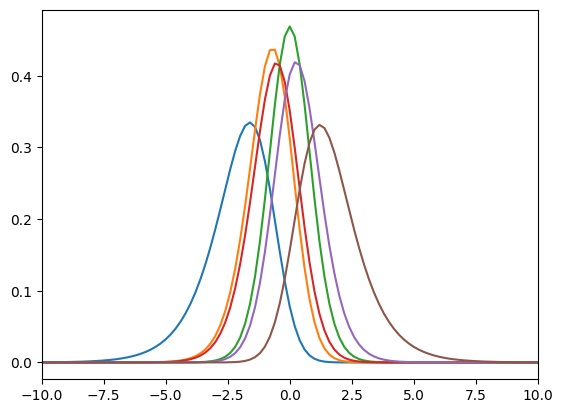

In [33]:
uuu = np.linspace(-30,30,301)
for kk in key6:
    yyy = posterior_u2(uuu, kk)
    plt.plot(uuu,yyy)
plt.xlim(-10,10)
plt.show()


$$
\int p(u)du = \lim_{n \rightarrow \infty} \frac{L}{n} \sum p(u_i) = 1
$$

1.0000000002773222
4.025189579620836


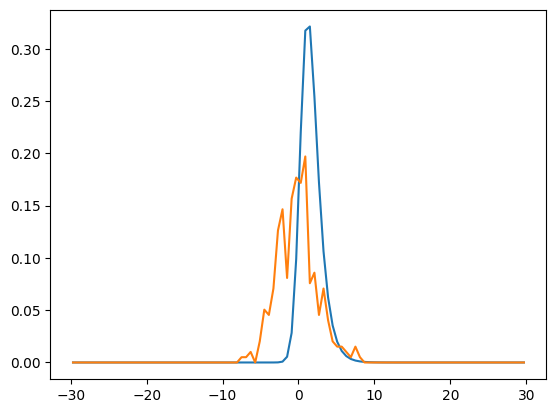

In [34]:
kk = "22"
ll = 1.5
uuu = prd_1k_cv[:,flag["pleural"][kk],0]
dist_tmp = np.histogram(uuu*ll, density=True, bins=np.linspace(-30,30,101))
mids = (dist_tmp[1][1:] + dist_tmp[1][0:-1])/2
ppp = sigmoid(mids)
yyy = posterior_u2(mids, kk)
print(np.sum(yyy)*(30+30)/100)
print(np.sum(-yyy*np.log(dist_tmp[0]+1e-32)))
plt.plot(mids,yyy)
plt.plot(mids,dist_tmp[0])
plt.show()

In [35]:
def loss_mse6(target, ll):
    # Function to compute the Mean Squared Error (MSE) loss for the given target and weights ll.
    loss_tmp = []
    for kk in key6:
        # Select the appropriate predictions based on the target ("pleural" or "scoliosis").
        if target == "pleural":
            uuu = prd_1k_cv[:, flag["pleural"][kk], 0]
        elif target == "scoliosis":
            uuu = prd_1k_cv[:, flag["scoliosis"][kk], 1]

        # Compute the histogram of uuu*ll and normalize it.
        dist_tmp = np.histogram(uuu * ll, density=True, bins=np.linspace(-30, 30, 101))
        mids = (dist_tmp[1][1:] + dist_tmp[1][0:-1]) / 2

        # Compute the posterior probabilities and calculate the squared difference from the histogram.
        ppp = sigmoid(mids)
        yyy = posterior_u2(mids, kk)
        loss_tmp.append((dist_tmp[0] - yyy) ** 2)

    # Concatenate the loss values for all keys and compute the mean loss.
    loss_tmp = np.concatenate(loss_tmp)
    return np.mean(loss_tmp)

def loss_kl6(target, ll):
    # Function to compute the Kullback-Leibler (KL) divergence loss for the given target and weights ll.
    loss_tmp = []
    epsilon = 1e-32
    for kk in key6:
        # Select the appropriate predictions based on the target ("pleural" or "scoliosis").
        if target == "pleural":
            uuu = prd_1k_cv[:, flag["pleural"][kk], 0]
        elif target == "scoliosis":
            uuu = prd_1k_cv[:, flag["scoliosis"][kk], 1]

        # Compute the histogram of uuu*ll and normalize it.
        dist_tmp = np.histogram(uuu * ll, density=True, bins=np.linspace(-30, 30, 101))
        mids = (dist_tmp[1][1:] + dist_tmp[1][0:-1]) / 2

        # Compute the posterior probabilities and calculate the KL divergence.
        ppp = sigmoid(mids)
        yyy = posterior_u2(mids, kk)
        kl = np.sum(-yyy * np.log(dist_tmp[0] + epsilon))
        loss_tmp.append(kl)

    # Convert the loss values to an array and compute the mean loss.
    loss_tmp = np.array(loss_tmp)
    return np.mean(loss_tmp)

In [36]:
from scipy.optimize import minimize_scalar
lambda_mse_p = minimize_scalar(lambda ll: loss_mse6("pleural",ll), bounds=(0,2),method="bounded")
print("lambda_p =", lambda_mse_p["x"])
lambda_mse_s = minimize_scalar(lambda ll: loss_mse6("scoliosis",ll), bounds=(0,2), method="bounded")
print("lambda_s =", lambda_mse_s["x"])

lambda_p = 0.48163512961304417
lambda_s = 0.2792131746277643


In [37]:
print(loss_mse6("scoliosis", lambda_mse_s["x"]))

0.0029867531182416417


In [38]:
print(loss_mse6("pleural", lambda_mse_s["x"]))

0.004038196267444855


In [39]:
from scipy.optimize import minimize_scalar
lambda_kl_p = minimize_scalar(lambda ll: loss_kl6("pleural",ll), bounds=(0,2),method="bounded")
print("lambda_p =", lambda_kl_p["x"])
lambda_kl_s = minimize_scalar(lambda ll: loss_kl6("scoliosis",ll), bounds=(0,2), method="bounded")
print("lambda_s =", lambda_kl_s["x"])

lambda_p = 1.2359890029723357
lambda_s = 0.3723758746759794


In [40]:
print(loss_kl6("scoliosis", lambda_kl_s["x"]))

18.4352810346582


In [41]:
print(loss_kl6("pleural", lambda_kl_s["x"]))

21.596996947851363


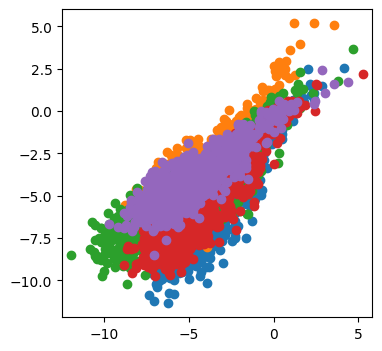

In [42]:
plt.figure(figsize=(4,4))
plt.scatter(prd_1k_cv[0,:,0],prd_1k_cv[1,:,0])
plt.scatter(prd_1k_cv[2,:,0],prd_1k_cv[3,:,0])
plt.scatter(prd_1k_cv[4,:,0],prd_1k_cv[5,:,0])
plt.scatter(prd_1k_cv[6,:,0],prd_1k_cv[7,:,0])
plt.scatter(prd_1k_cv[8,:,0],prd_1k_cv[9,:,0])
plt.axis("equal")
plt.show()

00


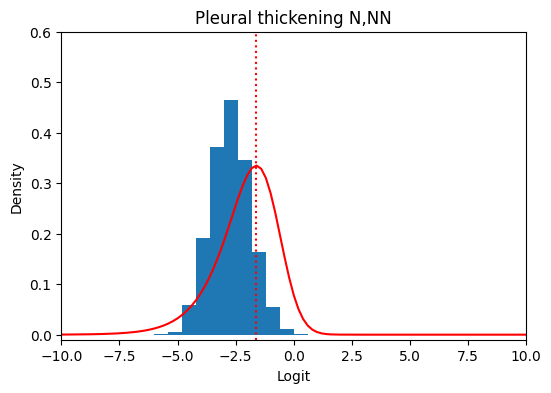

01


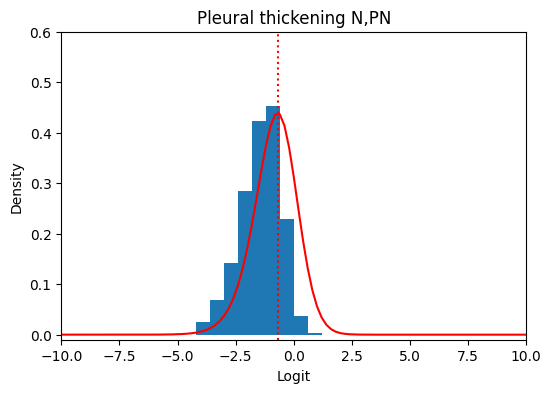

02


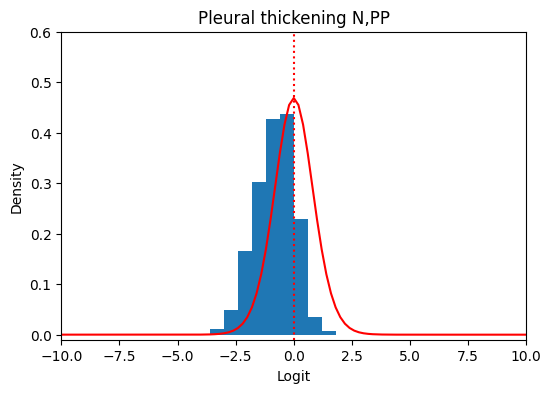

20


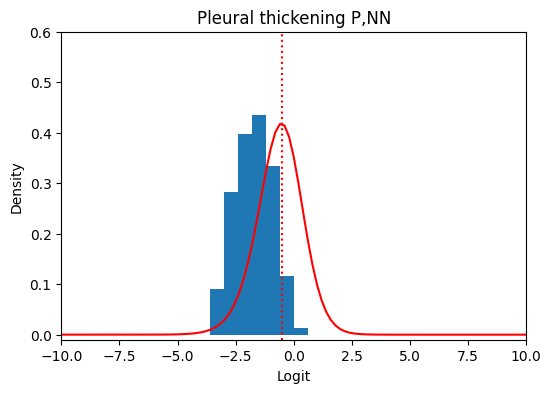

21


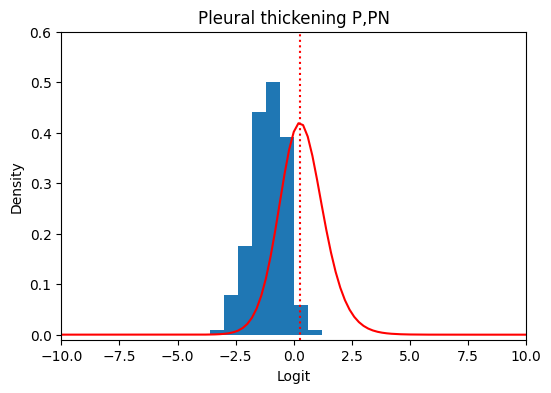

22


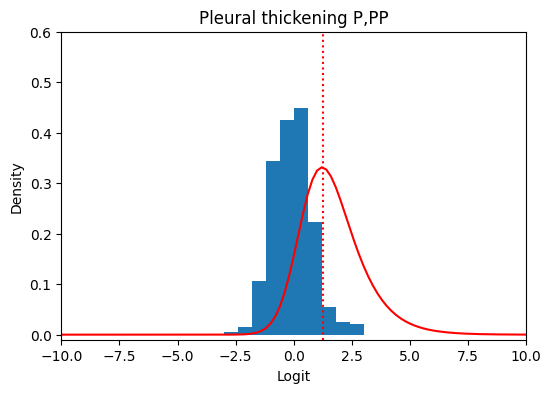

array([[1.        , 0.95585558],
       [0.95585558, 1.        ]])

In [44]:
rr_p = lambda_mse_p["x"]
prd_pleu_mean6 = []
for kk in key6:
    print(kk)
    plt.figure(figsize=(6,4))
    plt.title("Pleural thickening {}".format(label6[kk]))
    plt.xlabel("Logit")
    plt.ylabel("Density")
    tmp = prd_1k_cv[:,flag["pleural"][kk],0].reshape(-1)*rr_p
    plt.hist(tmp, density=True, bins=np.linspace(-30,30,101))
    xxx = np.linspace(-30,30,301)
    ppp = sigmoid(xxx)
    yyy = posterior_u2(xxx, kk)
    plt.plot(xxx,yyy, color="red")
    mean_tmp = np.mean(tmp)
    prd_pleu_mean6.append(mean_tmp)
    # plt.axvline(mean_tmp,0,100, color="blue", linestyle="dashed")
    plt.axvline(logit(p_hat[kk]),0,100, color="red", linestyle="dotted")
    plt.xlim((-10,10))
    plt.ylim((-0.01,0.6))
    plt.savefig("fig1/logit_dist_pleu_resnet101_{}.{}.pdf".format(kk,stamp), bbox_inches="tight", pad_inches=0.1)
    plt.show()

prd_pleu_mean6 = np.array(prd_pleu_mean6)
np.corrcoef(prd_pleu_mean6, p_hat6)


00


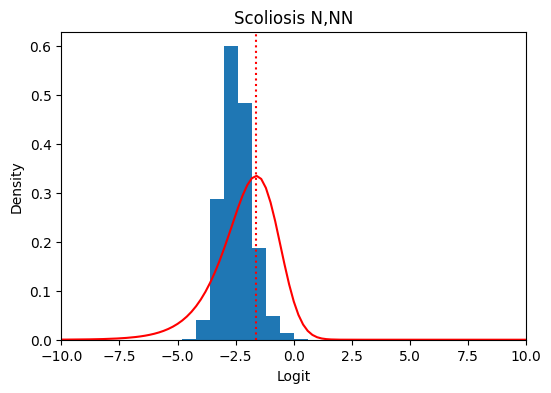

01


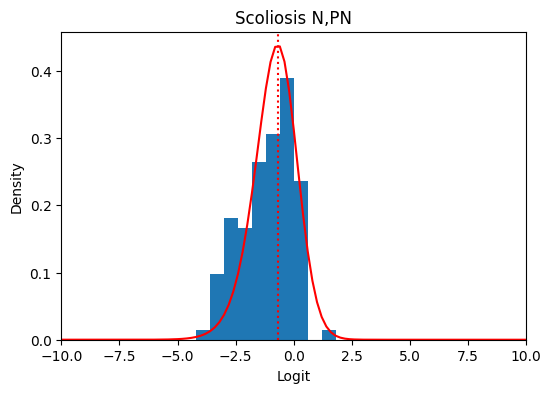

02


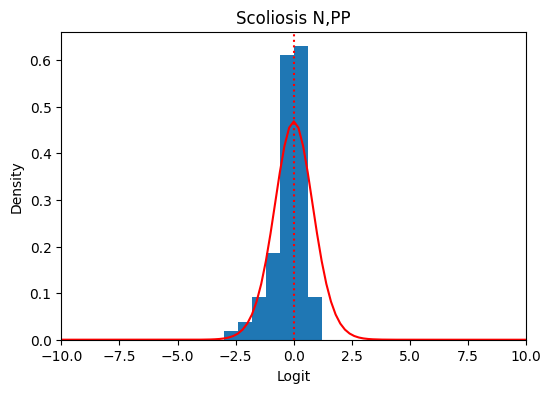

20


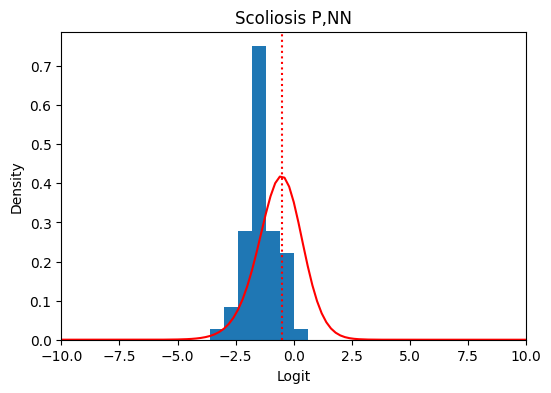

21


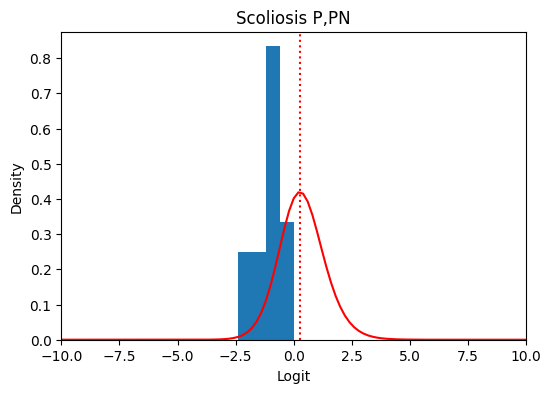

22


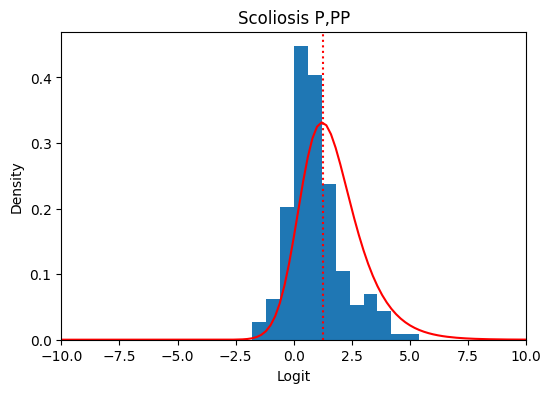

[[1.         0.92341535]
 [0.92341535 1.        ]]


In [45]:
rr_s = lambda_mse_s["x"]
prd_scol_median6 = []
prd_scol_mean6 = []
for kk in key6:
    print(kk)
    plt.figure(figsize=(6,4))
    plt.title("Scoliosis {}".format(label6[kk]))
    plt.xlabel("Logit")
    plt.ylabel("Density")
    tmp = prd_1k_cv[:,flag["scoliosis"][kk],1].reshape(-1)*rr_s
    plt.hist(tmp, density=True, bins=np.linspace(-30,30,101))
    xxx = np.linspace(-30,30,301)
    ppp = sigmoid(xxx)
    yyy = posterior_u2(xxx, kk)
    plt.plot(xxx,yyy, color="red")

    mean_tmp = np.mean(tmp)
    prd_scol_mean6.append(mean_tmp)
    median_tmp = np.median(tmp)
    prd_scol_median6.append(median_tmp)
    #plt.axvline(mean_tmp,0,100, color="blue", linestyle="dashed")
    #plt.axvline(median_tmp,0,100, color="blue", linestyle="dashed")
    plt.axvline(logit(p_hat[kk]),0,100, color="red", linestyle="dotted")
    plt.xlim((-10,10))
    plt.savefig("fig1/logit_dist_scol_resnet101_{}.{}.pdf".format(kk,stamp), bbox_inches="tight", pad_inches=0.1)
    plt.show()

prd_scol_mean6 = np.array(prd_scol_mean6)
print(np.corrcoef(prd_scol_mean6, p_hat6))
#prd_scol_median6 = np.array(prd_scol_median6)
#print(np.corrcoef(prd_scol_median6, p_hat6))


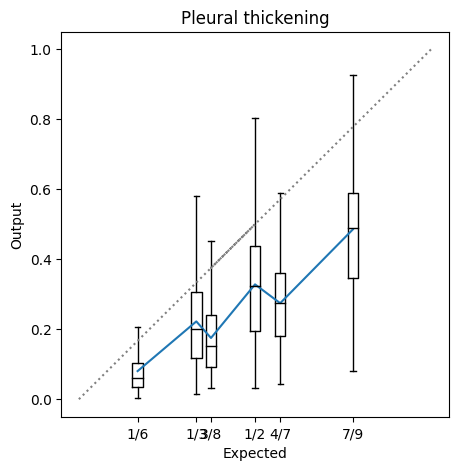

[0.08036233705049393, 0.22229486538469348, 0.1749823391170887, 0.3281763478506384, 0.2743829496233835, 0.4852679798420662]


array([[1.        , 0.95631873],
       [0.95631873, 1.        ]])

In [46]:
hoge = []
fuga = []

for key_tmp in np.array(key6,dtype=object)[idx_p6]:
    tmp = sigmoid(prd_1k_cv[:,flag["pleural"][key_tmp],0].reshape(-1)*rr_p)
    hoge.append(tmp)
    fuga.append(np.mean(tmp))
plt.figure(figsize=(5,5))
plt.title("Pleural thickening")
plt.xlabel("Expected")
plt.ylabel("Output")
plt.xlim((-0.05,1.05))
plt.ylim((-0.05,1.05))
plt.boxplot(hoge, positions=p_hat6[idx_p6], widths=0.03, labels=["1/6","1/3","3/8","1/2","4/7","7/9",], sym="", medianprops=dict(color='black', linewidth=1))
plt.plot(p_hat6[idx_p6], fuga)
tmp = np.concatenate([[0], p_hat6, [1]])
plt.plot(tmp, tmp, color="gray", linestyle="dotted")
plt.savefig("fig1/corr_pleu_resnet101.{}.pdf".format(stamp), bbox_inches="tight", pad_inches=0.1)

plt.show()

print(fuga)
np.corrcoef(p_hat6[idx_p6], fuga)



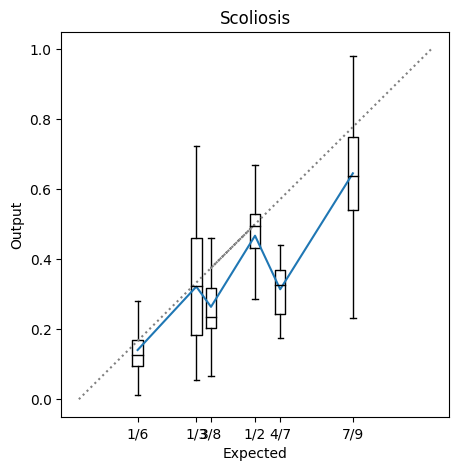

[0.1405522265555039, 0.3216946272711995, 0.26392500171264544, 0.4672302299651271, 0.31406668354694667, 0.6454765684672756]


array([[1.        , 0.90036544],
       [0.90036544, 1.        ]])

In [47]:
hoge = []
fuga = []
rr_s = 0.2165
for key_tmp in np.array(key6,dtype=object)[idx_p6]:
    tmp = sigmoid(prd_1k_cv[:,flag["scoliosis"][key_tmp],1].reshape(-1)*rr_s)
    hoge.append(tmp)
    fuga.append(np.mean(tmp))
plt.figure(figsize=(5,5))
plt.title("Scoliosis")
plt.xlabel("Expected")
plt.ylabel("Output")
plt.xlim((-0.05,1.05))
plt.ylim((-0.05,1.05))
plt.boxplot(hoge, positions=p_hat6[idx_p6], widths=0.03, labels=["1/6","1/3","3/8","1/2","4/7","7/9",], sym="", medianprops=dict(color='black', linewidth=1))
plt.plot(p_hat6[idx_p6], fuga)
tmp = np.concatenate([[0], p_hat6, [1]])
plt.plot(tmp, tmp, color="gray", linestyle="dotted")
plt.savefig("fig1/corr_scol_resnet101.{}.pdf".format(stamp), bbox_inches="tight", pad_inches=0.1)

plt.show()
print(fuga)
np.corrcoef(p_hat6[idx_p6], fuga)


### Validation 1K

$$
\int_0^1 x^m(1-x)^n = \frac{m!n!}{(m+n+1)!}
$$

$$
E_x[ p_{000}(x)] = \frac{\int_0^1 x(1-x)^4 }{\int_0^1 (1-x)^4} = \frac{4!}{6!} / \frac{4!}{5!} = \frac{1}{6}
$$

$$
E_x[ p_{001}(x)] = E_x[ p_{010}(x)] = \frac{\int_0^1 x^2(1-x)^3 }{\int_0^1 x(1-x)^3} = \frac{2!3!}{6!}/\frac{3!}{5!} = \frac{2}{6} = \frac{1}{3}
$$

$$
E_x[ p_{011}(x)] = \frac{\int_0^1 x^3(1-x)^2 }{\int_0^1 x^2(1-x)^2} = \frac{3!2!}{6!} / \frac{2!2!}{5!} = \frac{3}{6} = \frac{1}{2}
$$


$$
E_x[ p_{200}(x)] = \frac{\int_0^1 x(x^2(1-x)^2 + 2x(1-x)^3) }{\int_0^1  (x^2(1-x)^2 + 2x(1-x)^3)} = \frac{3!2!+2\times2!3!}{6!} / \frac{2!2!+2\times3!}{5!} =\frac{36}{6}\frac{1}{16} = \frac{3}{8}
$$

$$
E_x[ p_{201}(x)] = E_x[ p_{210}(x)] = \frac{\int_0^1 x(x^3(1-x)^1 + 2x^2(1-x)^2) }{\int_0^1 (x^3(1-x) + 2x^2(1-x)^2)} = \frac{4! + 2\times 3!2!}{6!}/\frac{3!+2\times2!2!}{5!} = \frac{48}{6}\frac{1}{14} = \frac{4}{7}
$$

$$
E_x[ p_{211}(x)] = \frac{\int_0^1 x(x^4 + 2x^3(1-x)) }{\int_0^1 x^4 + 2x^3(1-x)} = \frac{5! + 2\times 4!}{6!} / \frac{4! + 2\times 3!}{5!} = \frac{7\times 24}{6}\frac{1}{36} = \frac{7}{9}
$$


# GradCAM

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [60]:
prd_all_sample = np.zeros((n_sample, 2))
prd_1k_cv_sample = np.zeros((10, n_sample, 2))

for cv in range(10):
    path_load = "dat1/resnet101d_{}_cv{}_t{}.ckpt".format(stamp_load, cv, t0_load)
    model1.load_state_dict(torch.load(path_load,map_location=device))
    
    #Calculate the probabilities of training data.
    model1.eval()
    with torch.inference_mode():
        batch_list = make_batch_list(idx_cv10[cv], batch_size=batch_size, shuffle=False)
        for idx_tmp in batch_list:
            xxx_tmp, yyy_tmp = generate_batch(idx_tmp, pix_all, target_all, augment=False)
            
            out_tmp = model1(xxx_tmp)
            prd_all_sample[idx_tmp,:] = out_tmp.detach().cpu().numpy()
    
    #Calculate the probabilities of test data.
    model1.eval()
    with torch.inference_mode():
        batch_list = make_batch_list(np.arange(n_sample), batch_size=batch_size, shuffle=False)
        for idx_tmp in batch_list:
            xxx_tmp, yyy_tmp = generate_batch(idx_tmp, pix_20210708, target_1k, augment=False)

            out_tmp = model1(xxx_tmp)

            prd_1k_cv_sample[cv,idx_tmp] = out_tmp.detach().cpu().numpy()


In [61]:
class GradCAM:
    def __init__(self, feature_layer):
        """
        Initialize the GradCAM class with the specified feature_layer.
        This feature_layer will be used for extracting feature maps and gradients.

        Args:
            feature_layer (torch.nn.Module): The feature extraction layer of the model.

        Returns:
            None
        """
        self.feature_layer = feature_layer
        self.feature_grad = None
        self.feature_map = None
        self.hooks = []

        # Register a backward hook to record gradients during the backward pass of the final layer.
        def save_feature_grad(module, in_grad, out_grad):
            self.feature_grad = out_grad[0]
        self.hooks.append(self.feature_layer.register_full_backward_hook(save_feature_grad))

        # Register a forward hook to record the feature map from the final layer.
        def save_feature_map(module, inp, outp):
            self.feature_map = outp[0]
        self.hooks.append(self.feature_layer.register_forward_hook(save_feature_map))

    def backward_on_target(self, output, target):
        """
        Calculate one-hot encoded target for computing gradients and perform a backward pass.
        The gradients are computed with respect to the target class.

        Args:
            output (torch.Tensor): The output tensor of the model.
            target (int): The target class index.

        Returns:
            None
        """
        # Calculate one-hot encoded target for computing gradients.
        one_hot_output = torch.zeros([1, output.size()[-1]], device=output.device)
        one_hot_output[0][target] = 1

        # Perform a backward pass with the one-hot encoded target to compute gradients.
        output.backward(gradient=one_hot_output, retain_graph=True)

    def clear_hooks(self):
        """
        Remove the registered hooks to free up resources.

        Args:
            None

        Returns:
            None
        """
        # Remove the registered hooks to free up resources.
        for hook in self.hooks:
            hook.remove()

In [62]:
def cal_cam(pix, jj):
    # Reshape the pixel values and convert to a tensor, then move it to the GPU.
    xxx_tmp = transform_val(pix).reshape((1, 3, ny, nx)).cuda()

    # Pass the tensor through the model1 (neural network).
    out_tmp = model1(xxx_tmp)

    # Compute the gradients using Grad-CAM on the target class (jj).
    grad_cam.backward_on_target(out_tmp, jj)
    feature_grad = grad_cam.feature_grad
    feature_map = grad_cam.feature_map

    # Calculate weights by taking the average of feature gradients.
    weights = torch.mean(feature_grad, axis=(0, 2, 3))

    # Calculate the class activation map (CAM) using weights and feature maps.
    cam = torch.sum(torch.relu(weights.view(2048, 1, 1) * feature_map), dim=0)
    
    # Resize the CAM to match the original image size and normalize the values between 0-1.
    img_cam = cv2.resize(cam.cpu().detach().numpy(), (ny, nx), interpolation=cv2.INTER_CUBIC)
    img_cam = (img_cam - np.min(img_cam)) / (np.max(img_cam) - np.min(img_cam))

    # Scale the values between 0-255 to visualize the CAM.
    img_cam = np.uint8(img_cam * 255)
    
    return img_cam



In [63]:
def blend_cam(xxx_src, cam):
    # Apply a color map (JET colormap) to the CAM to convert it to a colored heatmap.
    cv_cam = cv2.applyColorMap(cam, cv2.COLORMAP_JET)

    # Alpha blending of the source image (xxx_src) and the colored heatmap (cv_cam).
    alpha = 0.6  # Set the blending ratio, where 0.6 indicates 60% opacity for the source image.
    cv_blended = cv2.addWeighted(xxx_src, alpha, cv_cam, 1 - alpha, 0)

    # Convert the blended image to RGB color space (from BGR).
    img_blended = cv2.cvtColor(cv_blended, cv2.COLOR_BGR2RGB)

    return img_blended

In [64]:
for aa,hoge in enumerate(list(model1.modules())):
    print(aa, hoge)


0 MyNet(
  (model): ResNet(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [73]:
module_index = 360
print(list(model1.modules())[module_index]) # 4x4
grad_cam = GradCAM(list(model1.modules())[module_index])

Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [74]:
def to_RGB(data):
    img = Image.fromarray(np.uint16(data))
    img = img.convert("RGB")
    return(np.asarray(img))

In [75]:
jj = 1 # scoliosis
ii = np.argsort(prd_all_sample[:,jj])[-1]
xxx_tmp = transform_val(pix_all[ii]).reshape((1,3,ny,nx)).cuda()

out_tmp = model1(xxx_tmp)
grad_cam.backward_on_target(out_tmp,jj)
# out_tmp = F.softmax(.reshape(-1, 2), dim=1)

# one_hot_output = torch.zeros([1, 2]).cuda()
# one_hot_output[0,jj] = 1
# out_tmp.backward(gradient=one_hot_output, retain_graph=True)
feature_grad = grad_cam.feature_grad
feature_map = grad_cam.feature_map


In [76]:
print(feature_grad.shape)
print(feature_map.shape)

torch.Size([1, 2048, 16, 16])
torch.Size([2048, 16, 16])


pleural thickening
[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 0]]


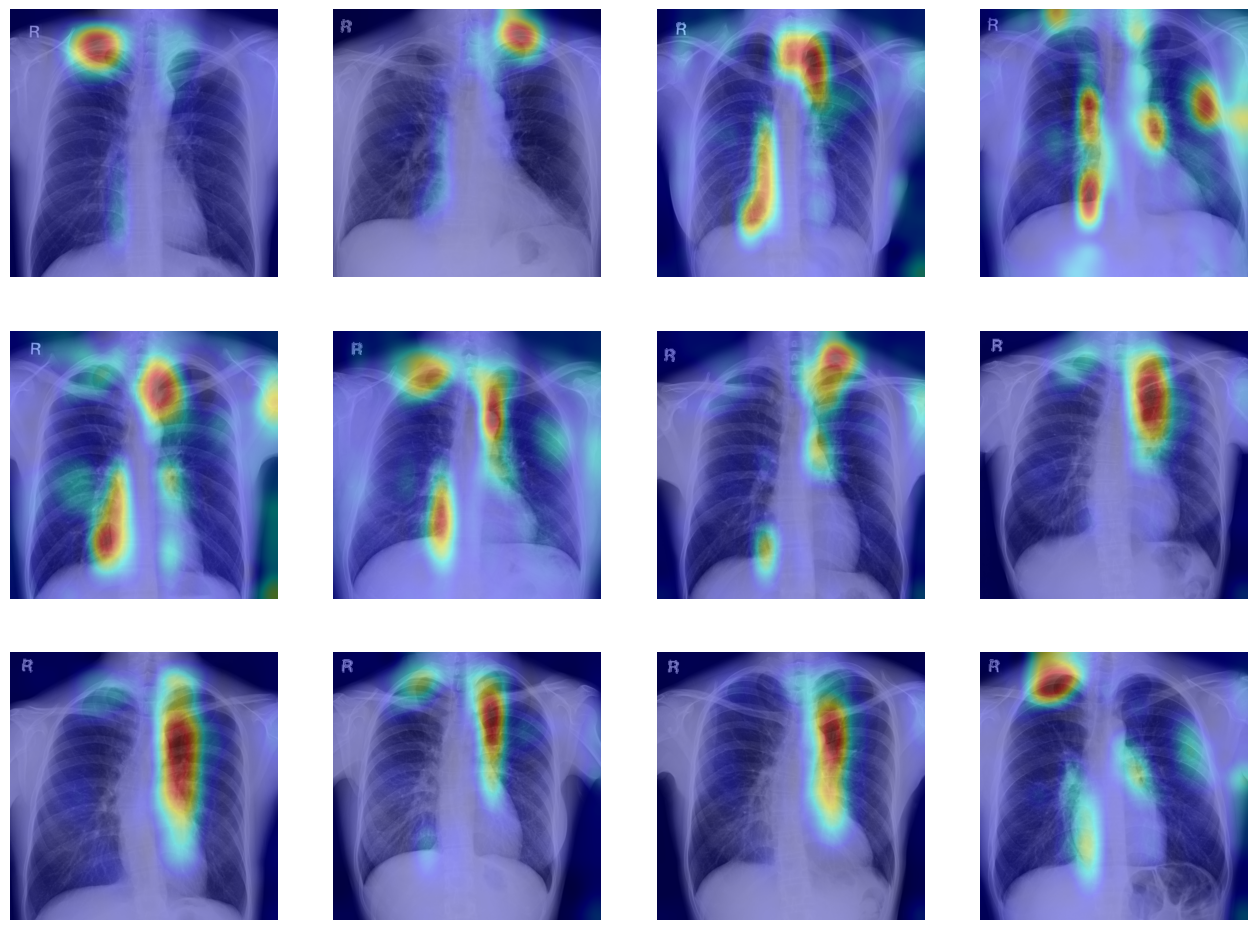

In [77]:
print("pleural thickening")

plt.figure(figsize=(4*4,4*4))

jj = 0
a1 = 0

idx_tmp = np.argsort(prd_all_sample[:,0])[::-1]

model1.eval()
print(target_all[idx_tmp[a1:(a1+4*4)],:])
for aa,ii in enumerate(idx_tmp[a1:(a1+4*4)]):
    cam_tmp = cal_cam(pix_all[ii], jj)
    img_tmp = to_RGB(pix_all[ii])
    img_cam = blend_cam(img_tmp, cam_tmp)
    plt.subplot(4,4,aa+1)
    plt.imshow(img_cam)
    plt.axis("off")
plt.show()

Scoliosis
[[0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [1 0]
 [0 0]]


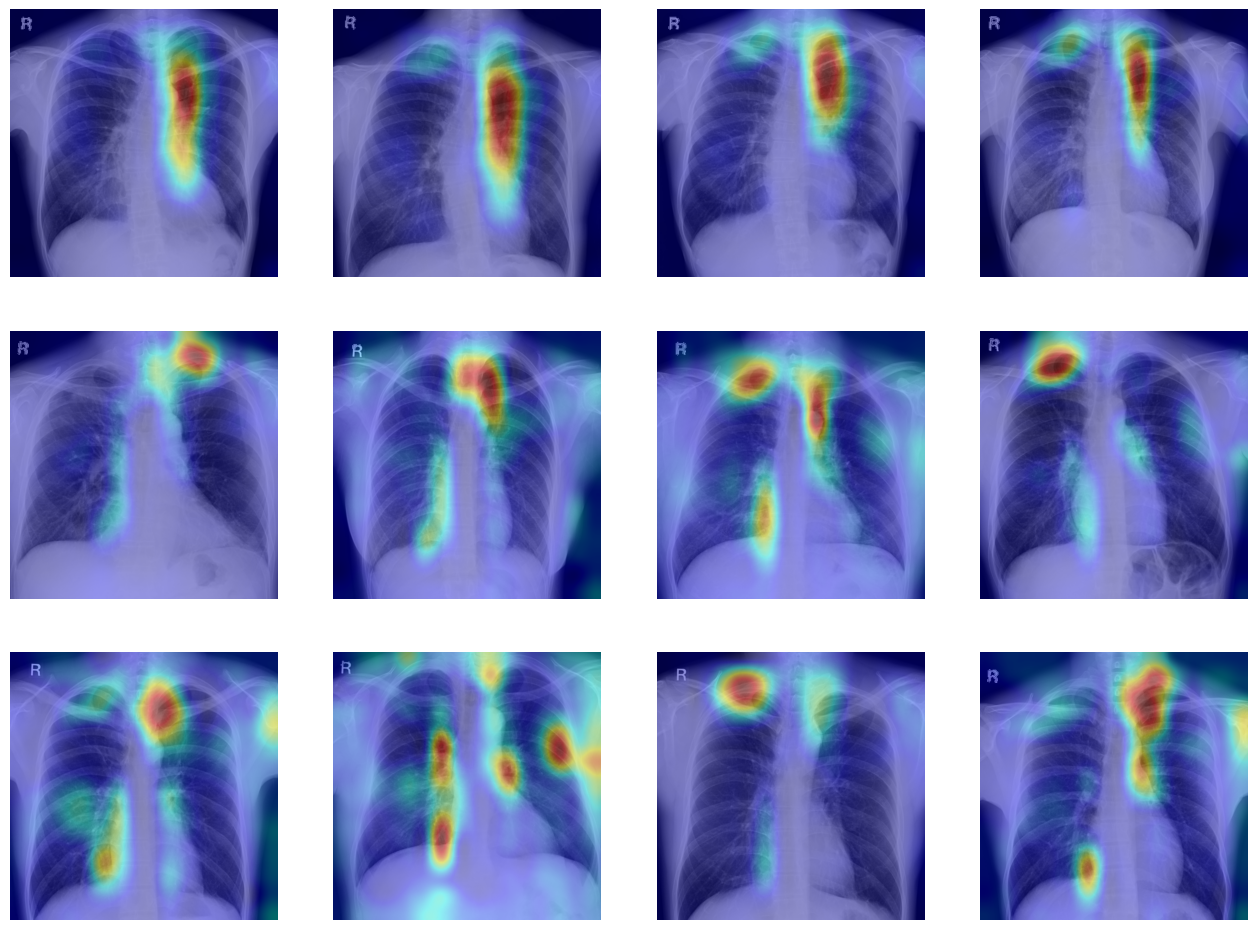

In [78]:
print("Scoliosis")

plt.figure(figsize=(4*4,4*4))

jj = 1
a1 = 0

idx_tmp = np.argsort(prd_all_sample[:,jj])[::-1]

model1.eval()
print(target_all[idx_tmp[a1:(a1+4*4)],:])
for aa,ii in enumerate(idx_tmp[a1:(a1+4*4)]):
    cam_tmp = cal_cam(pix_all[ii], jj)
    img_tmp = to_RGB(pix_all[ii])
    img_cam = blend_cam(img_tmp, cam_tmp)
    plt.subplot(4,4,aa+1)
    plt.imshow(img_cam)
    plt.axis("off")
plt.show()